# Assignment 5

This assignment has weighting $1.5$.

# Model tuning and evaluation

In [63]:
# Added version check for recent scikit-learn 0.18 checks
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

## Dataset

We will use the Wisconsin breast cancer dataset for the following questions

In [64]:
import pandas as pd

#wdbc_source = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data'
wdbc_source = '../datasets/wdbc/wdbc.data'

df = pd.read_csv(wdbc_source, header=None)

In [65]:
from sklearn.preprocessing import LabelEncoder
X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.transform(['M', 'B'])

array([1, 0], dtype=int64)

In [66]:
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.20, random_state=1)

In [67]:
%matplotlib inline

# K-fold validation (20 points)

Someone wrote the code below to conduct cross validation.
Do you see anything wrong with it?
And if so, correct the code and provide an explanation.

## Answer

In the original code, partial_fit was used which fits on trained data and therefore would not give accurate results. Therefore, the in the corrected code, partial_fit was changed to fit. And a pipeline for the required methods to be done for each fold was made. 
Also, since there were two loops, inner loop is expected to find the correct hyper parameters and the outer loop should train with the optimal parameters. 
But this result was not achieved since the training happened in the inner loop. Therefore, grid search method is used to find hyper parameters and K-fold cross validation is used to divide the model into training and testing sets and then train the model using optimal parameters.  


In [68]:
import numpy as np
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import Perceptron
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV

if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import StratifiedKFold
else:
    from sklearn.model_selection import StratifiedKFold

pipe_p = Pipeline([('scl', StandardScaler()),
                    ('clf', Perceptron(random_state=1))])

if Version(sklearn_version) < '0.18':
    kfold = StratifiedKFold(y=y_train, 
                            n_folds=10,
                            random_state=1)
else:
    kfold = StratifiedKFold(n_splits=10,
                            random_state=1).split(X_train, y_train)

num_epochs = 2
param_grid = [{'clf__random_state': [1]}]

gs = GridSearchCV(estimator=pipe_p,
                  param_grid = param_grid,
                  cv=num_epochs)

scores = []
for k, (train, test) in enumerate(kfold):
    gs.fit(X_train[train], y_train[train])
    score = gs.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k+1,
          np.bincount(y_train[train]), score))
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold: 1, Class dist.: [256 153], Acc: 0.891
Fold: 2, Class dist.: [256 153], Acc: 0.978
Fold: 3, Class dist.: [256 153], Acc: 0.957
Fold: 4, Class dist.: [256 153], Acc: 0.935
Fold: 5, Class dist.: [256 153], Acc: 0.978
Fold: 6, Class dist.: [257 153], Acc: 1.000
Fold: 7, Class dist.: [257 153], Acc: 0.956
Fold: 8, Class dist.: [257 153], Acc: 0.978
Fold: 9, Class dist.: [257 153], Acc: 0.978
Fold: 10, Class dist.: [257 153], Acc: 0.978

CV accuracy: 0.963 +/- 0.029


# Precision-recall curve (40 points)

We have plotted ROC (receiver operator characteristics) curve for the breast cancer dataset.

Plot the precision-recall curve for the same data set using the same experimental setup.
What similarities and differences you can find between ROC and precision-recall curves?

You can find more information about precision-recall curve online such as: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html

# Answer

## Explaination
The graphs for ROC and Precision-Recall have opposite slopes. The perfect performance for Precision and Recall and ROC can be compared by the horizontal straight line. Both the graphs have sharp ups and downs.

In [69]:
import numpy as np
from sklearn.metrics import precision_recall_curve, auc

y_truth = np.array([0, 0, 1, 1])

#y_score = np.array([0, 0, 1, 1]) # completely right
y_score = np.array([0.1, 0.4, 0.35, 0.8]) # partially right
#y_score = np.array([1, 1, 0, 0]) # completely wrong

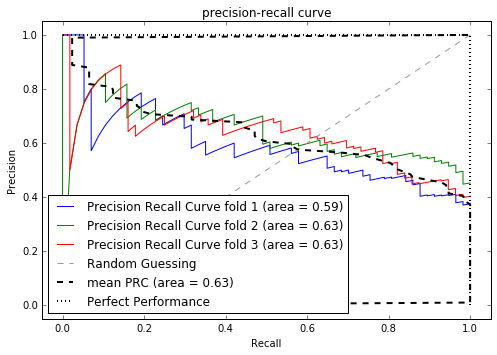

In [85]:
from sklearn.metrics import precision_recall_curve, auc
from scipy import interp
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(penalty='l2', 
                                               random_state=0, 
                                               C=100.0))])

# intentionally use only 2 features to make the task harder and the curves more interesting
X_train2 = X_train[:, [4, 14]]
X_test2 = X_test[:, [4, 14]]

cv = StratifiedKFold(y_train, 
                         n_folds=3, 
                         random_state=1)

fig = plt.figure(figsize=(7, 5))

mean_recall = 0.0
mean_precision = np.linspace(0, 1, 100)
all_recall = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])

    precision, recall, thresholds = precision_recall_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_recall += interp(mean_precision, precision, recall)
    #mean_tpr[0] = 0.0
    prc_auc = auc(recall, precision)
    plt.plot(recall,
             precision,
             lw=1,
             label='Precision Recall Curve fold %d (area = %0.2f)'
                   % (i+1, prc_auc))

plt.plot([1, 0],
         [1, 0],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='Random Guessing')

mean_recall /= len(cv)
mean_recall[0] = 0.0
mean_recall[-1] = 1.0
mean_auc = auc(mean_precision, mean_recall)
plt.plot(mean_recall, mean_precision, 'k--',
         label='mean PRC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 1, 1],
         [1, 1, 0],
         lw=2,
         linestyle=':',
         color='black',
         label='Perfect Performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('precision-recall curve')
plt.legend(loc="lower left")

plt.tight_layout()
# plt.savefig('./figures/roc.png', dpi=300)
plt.show()

# Ensemble learning

We have used the following code to compute and plot the ensemble error from individual classifiers for binary classification:

In [71]:
from scipy.misc import comb
import math
import numpy as np

def ensemble_error(num_classifier, base_error):
    k_start = math.ceil(num_classifier/2)
    probs = [comb(num_classifier, k)*(base_error**k)*((1-base_error)**(num_classifier-k)) for k in range(k_start, num_classifier+1)]
    return sum(probs)

In [72]:
import matplotlib.pyplot as plt
%matplotlib inline

In [73]:
def plot_base_error(ensemble_error_func, num_classifier, error_delta):

    error_range = np.arange(0.0, 1+error_delta, error_delta)
    ensemble_errors = [ensemble_error_func(num_classifier=num_classifier, base_error=error) for error in error_range]

    plt.plot(error_range, ensemble_errors, 
             label = 'ensemble error',
             linewidth=2)
    plt.plot(error_range, error_range,
             label = 'base error',
             linestyle = '--',
             linewidth=2)
    plt.xlabel('base error')
    plt.ylabel('base/ensemble error')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [74]:
num_classifier = 11
error_delta = 0.01
base_error = 0.25

In [75]:

print(ensemble_error(num_classifier=num_classifier, base_error=base_error))


0.034327507019


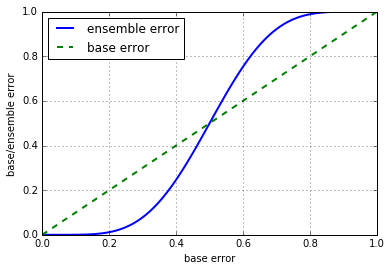

In [76]:
plot_base_error(ensemble_error, num_classifier=num_classifier, error_delta=error_delta)

# Number of classifiers (40 points)

The function plot_base_error() above plots the ensemble error as a function of the base error given a fixed number of classifiers.

Write another function to plot ensembe error versus different number of classifiers with a given base error.

Does the ensemble error always go down with more classifiers? 
Why or why not?

Can you improve the method ensemble_error() to produce a more reasonable plot?

## Answer

The code for plotting is below:

In [77]:
def plot_num_classifier(ensemble_error_func, max_num_classifier, base_error):
    num_range = np.arange(1, 1+max_num_classifier, 1)
    ensemble_errors = [ensemble_error_func(num_classifier=classifier, base_error=base_error) for classifier in num_range]
    plt.plot(num_range, ensemble_errors, 
             label = 'ensemble error',
             linewidth=2)
    plt.xlabel('num classifier')
    plt.ylabel('base/ensemble error')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

## Observations
When the base error is less than 0.5, the ensemble error sees a downhill trend. But when the base error is 0.5, the ensemble error does not go below 0.5. When the base error is 0.75, the ensemble error values increase with the increase in number of classifiers. So the base error is a really important factor to determine the ensemble error's behaviour. 
Therefore, it is clear that the ensemble error does not always go down with increase in the number of classifiers. This is because if the number of classifiers increase but all of them have 3/4th chances of being wrong, then overall there will be higher chance of the majority of the classifiers predicting wrong results. 

In [78]:
max_num_classifiers = 20
base_error = 0.3

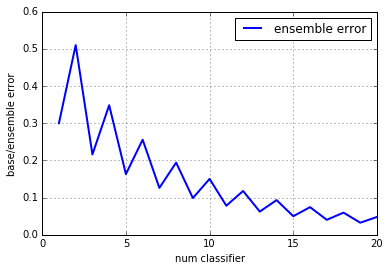

In [79]:
plot_num_classifier(ensemble_error, 
                    max_num_classifier=max_num_classifiers, 
                    base_error=base_error)

Explain your observations above.

Describe a better algorithm for computing the ensemble error.

## Explanation
In the above method, we did not take into consideration the 50-50 possiblity of when the number of classifiers are even, probability that the half of the classifiers are wrong is true only half of the times. In the better ensemble error algorithm, this is taken into consideration and therefore, there is a smoother curve for the ensemble error. 

In [80]:
def better_ensemble_error(num_classifier, base_error):
    # replace the following default line with your implementation of a better algorithm for ensemble error
    k_start = math.ceil(num_classifier/2)
    probs = []
    for k in range(k_start, num_classifier+1):
        if (num_classifier%2 == 0 and k==k_start):
            probs.append((comb(num_classifier, k)*(base_error**k)*((1-base_error)**(num_classifier-k)))/2)
        else:
            probs.append((comb(num_classifier, k)*(base_error**k)*((1-base_error)**(num_classifier-k))))
    return sum(probs)

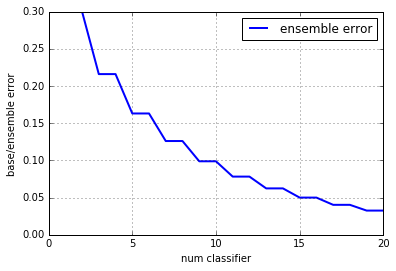

In [81]:
plot_num_classifier(better_ensemble_error, 
                    max_num_classifier=max_num_classifiers, 
                    base_error=base_error)